In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
edges = pd.read_csv('../data/edges_raw.csv')

In [4]:
edges.head()

source_name    target_name                               url
0      oreshkins         dumatv     https://t.me/s/oreshkins/8017
1  north_eurasia  north_eurasia  https://t.me/s/north_eurasia/290
2  north_eurasia  north_eurasia  https://t.me/s/north_eurasia/289
3  north_eurasia  north_eurasia  https://t.me/s/north_eurasia/287
4  north_eurasia  north_eurasia  https://t.me/s/north_eurasia/286

File above can be imported to Gephi as is, but you also may want to drop duplicates first of groupby and count unique post urls to wheight edges.

In [5]:
dates = pd.read_csv('../data/post_dates.csv', parse_dates=['date'])

In [6]:
dates.head()

channel                                 url  \
0  alliance_freedom  https://t.me/s/alliance_freedom/91   
1  alliance_freedom  https://t.me/s/alliance_freedom/90   
2  alliance_freedom  https://t.me/s/alliance_freedom/89   
3  alliance_freedom  https://t.me/s/alliance_freedom/88   
4  alliance_freedom  https://t.me/s/alliance_freedom/87   

                       date  
0 2023-06-24 15:06:38+00:00  
1 2023-06-24 13:58:06+00:00  
2 2023-06-24 13:49:42+00:00  
3 2023-06-24 09:30:22+00:00  
4 2023-06-24 07:45:18+00:00

Dates can be used to filter graph by events

# Filter edges by repost rate

In [7]:
edges.drop_duplicates(subset='url', inplace=True)
merged = edges.merge(dates, on='url', how='inner')

In [8]:
merged.drop_duplicates(subset=['url'], inplace=True)
count_df = dates.drop_duplicates(subset=['url']).groupby('channel')['url'].count().reset_index()

In [9]:
merged['count'] = 1
merged_gb = merged.groupby(['source_name', 'target_name'])['count'].sum().reset_index()

In [10]:
count_df.columns = ['source_name', 'total_posts']

In [11]:
merged_gb = merged_gb.merge(count_df, on='source_name')
merged_gb = merged_gb[merged_gb['source_name'] != merged_gb['target_name']].copy()
merged_gb['share'] = merged_gb['count'] / merged_gb['total_posts']

### Lets see how share of repost of each channel is distributed against total post number for each channel

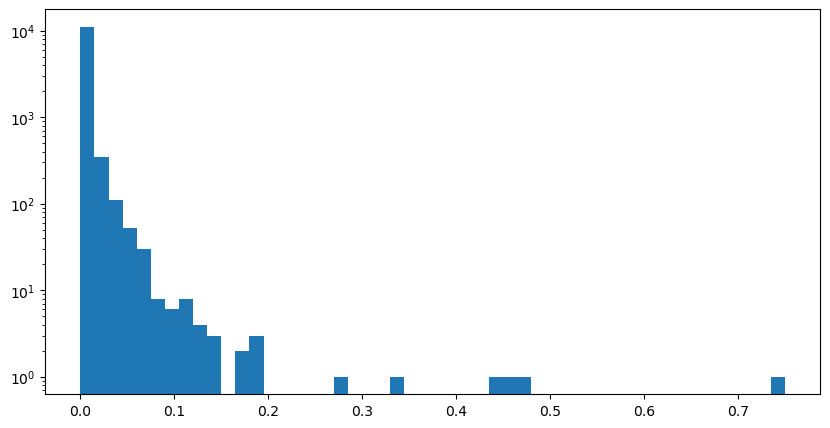

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(merged_gb['share'].values, bins=50, log=True);

### And how how many channels will left after filtering by different thresholds
Steps shows existence of some dense groups

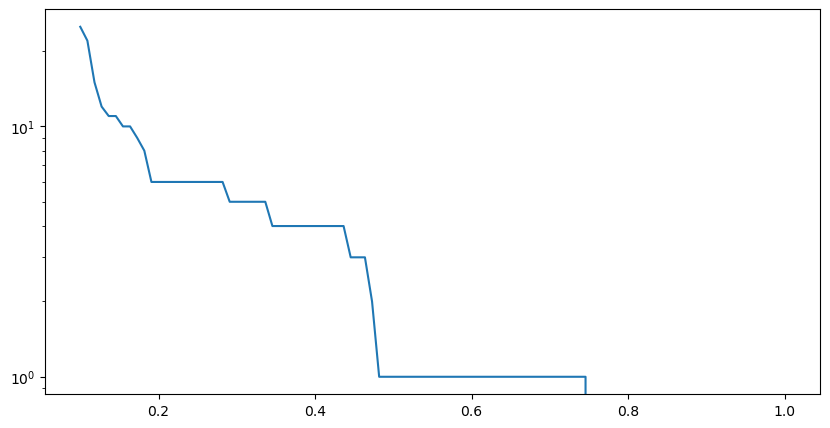

In [13]:
gb_filtered = merged_gb

temp = []
for thr in np.linspace(0.1, 1, 100):
    temp.append(gb_filtered[gb_filtered['share'] > thr]['target_name'].nunique())
    
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0.1, 1, 100), temp)
plt.yscale('log');


### But previous estimation also contains share of original content. Let's check share of reposts against other reposts

In [14]:
repost_count = merged_gb.groupby('source_name')['count'].sum().reset_index()
repost_count.columns = ['source_name', 'repost_count']

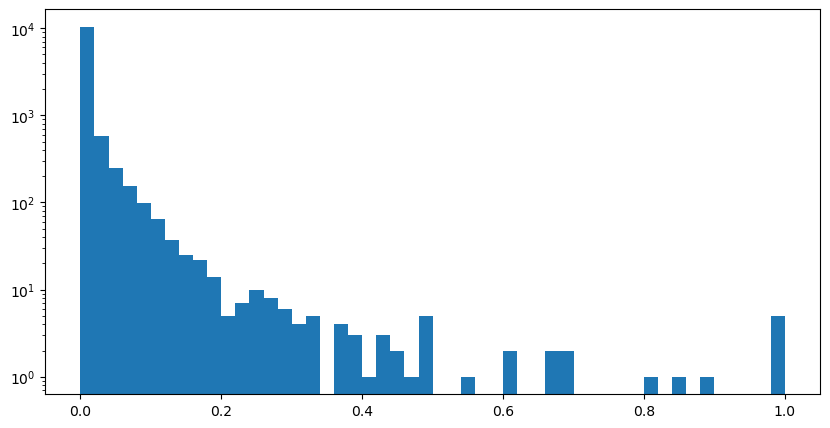

In [15]:
merged_gb = merged_gb.merge(repost_count, on='source_name', how='left')
merged_gb['repost_share'] = merged_gb['count'] / merged_gb['repost_count']

plt.figure(figsize=(10, 5))
plt.hist(merged_gb['repost_share'].values, bins=50, log=True);

In [16]:
gb_filtered = merged_gb

temp = []
for thr in np.linspace(0.1, 1, 100):
    temp.append(gb_filtered[gb_filtered['repost_share'] > thr]['target_name'].nunique())
    
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0.1, 1, 100), temp)
plt.yscale('log');

### Now we can make a filter function that clips the data by date and drop rare reposts by given share threshold

In [17]:
def make_all(merged, dates, date, thr=0.05):
    mask = merged['date'].dt.tz_localize(None) <= date
    merged_gb = merged[mask].groupby(['source_name', 'target_name'])['count']\
        .sum().reset_index()


    count_df = dates[dates['date'].dt.tz_localize(None) <= date].drop_duplicates(subset=['url']).groupby('channel')['url'].count().reset_index()
    count_df.columns = ['source_name', 'total_posts']
    merged_gb = merged_gb.merge(count_df, on='source_name')
    merged_gb = merged_gb[merged_gb['source_name'] != merged_gb['target_name']].copy()
    merged_gb['share'] = merged_gb['count'] / merged_gb['total_posts']

    merged_gb['share'] = merged_gb['count'] / merged_gb['total_posts']

    repost_count = merged_gb.groupby('source_name')['count'].sum().reset_index()
    repost_count.columns = ['source_name', 'repost_count']

    merged_gb = merged_gb.merge(repost_count, on='source_name', how='left')
    merged_gb['repost_share'] = merged_gb['count'] / merged_gb['repost_count']

    core = merged_gb[merged_gb['repost_share'] > thr].copy()
    return core

In [18]:
before_rdk = make_all(merged, dates, pd.to_datetime('2023-05-25'), thr=0.05)

In [19]:
before_rdk.head()

source_name       target_name  count  total_posts     share  \
148             aknrf        idelrealii    330         3788  0.087117   
440  alliance_freedom     altruist_news      1           24  0.041667   
441  alliance_freedom    free_chuvashia      1           24  0.041667   
442  alliance_freedom        karjala474      2           24  0.083333   
443  alliance_freedom  oreshnikov_mishi      1           24  0.041667   

     repost_count  repost_share  
148          3479      0.094855  
440             8      0.125000  
441             8      0.125000  
442             8      0.250000  
443             8      0.125000

### Now save it in format readable by Gephi

In [20]:
before_rdk[
    ['source_name', 'target_name', 'repost_share']
    ].to_csv('../data/before_rdk.csv',
              index=False, header=['Source', 'Target', 'Weight'])
